<a href="https://colab.research.google.com/github/Bossism/DailyStudy/blob/master/PyTorchBasicKnowledge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 基本配置

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optimizer

In [ ]:
batch_size = 64
lr = 1e-4
max_epochs = 100

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

### 数据读入

In [11]:
import torchvision.datasets as datasets

train_dataset = datasets.CIFAR10(root='./', train=True, transform=None, download=True)
test_dataset = datasets.CIFAR10(root='./', train=False, transform=None, download=True)
print(len(train_dataset))
print(len(test_dataset))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified
50000
10000


### 模型构建

神经网络的构建

In [13]:
import torch
from torch import nn

class MLP(nn.Module):
  # 声明带有模型参数的层，这里声明了两个全连接层
  def __init__(self, **kwargs):
    # 调用MLP父类Block的构造函数来进行必要的初始化。这样在构造实例时还可以指定其他函数
    super(MLP, self).__init__(**kwargs)
    self.hidden = nn.Linear(784, 256)
    self.act = nn.ReLU()
    self.output = nn.Linear(256,10)
    
   # 定义模型的前向计算，即如何根据输入x计算返回所需要的模型输出
  def forward(self, x):
    o = self.act(self.hidden(x))
    return self.output(o)   


In [14]:
X = torch.rand(2,784)
net = MLP()
print(net)
net(X)


MLP(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (act): ReLU()
  (output): Linear(in_features=256, out_features=10, bias=True)
)


tensor([[-0.0393, -0.0339,  0.1224,  0.1934,  0.1817,  0.1160, -0.0736, -0.1075,
         -0.1061, -0.2813],
        [-0.0992, -0.0917,  0.1682,  0.2004,  0.0797,  0.2025, -0.1220, -0.0687,
         -0.1975, -0.0975]], grad_fn=<AddmmBackward>)

神经网络中常见的层

不含模型参数的层

In [15]:
# 不含模型参数的层
import torch
from torch import nn

class MyLayer(nn.Module):
    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)
    def forward(self, x):
        return x - x.mean()  

layer = MyLayer()
layer(torch.tensor([1, 2, 3, 4, 5], dtype=torch.float))

tensor([-2., -1.,  0.,  1.,  2.])

含模型参数的层

In [16]:
class MyListDense(nn.Module):
    def __init__(self):
        super(MyListDense, self).__init__()
        self.params = nn.ParameterList([nn.Parameter(torch.randn(4, 4)) for i in range(3)])
        self.params.append(nn.Parameter(torch.randn(4, 1)))

    def forward(self, x):
        for i in range(len(self.params)):
            x = torch.mm(x, self.params[i])
        return x
net = MyListDense()
print(net)


MyListDense(
  (params): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 4x4]
      (1): Parameter containing: [torch.FloatTensor of size 4x4]
      (2): Parameter containing: [torch.FloatTensor of size 4x4]
      (3): Parameter containing: [torch.FloatTensor of size 4x1]
  )
)


In [17]:
class MyDictDense(nn.Module):
    def __init__(self):
        super(MyDictDense, self).__init__()
        self.params = nn.ParameterDict({
                'linear1': nn.Parameter(torch.randn(4, 4)),
                'linear2': nn.Parameter(torch.randn(4, 1))
        })
        self.params.update({'linear3': nn.Parameter(torch.randn(4, 2))}) # 新增

    def forward(self, x, choice='linear1'):
        return torch.mm(x, self.params[choice])

net = MyDictDense()
print(net)


MyDictDense(
  (params): ParameterDict(
      (linear1): Parameter containing: [torch.FloatTensor of size 4x4]
      (linear2): Parameter containing: [torch.FloatTensor of size 4x1]
      (linear3): Parameter containing: [torch.FloatTensor of size 4x2]
  )
)


池化层

In [23]:
import torch
from torch import nn

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y


In [25]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
pool2d(X, (2, 2))


tensor([[4., 5.],
        [7., 8.]])

LeNet

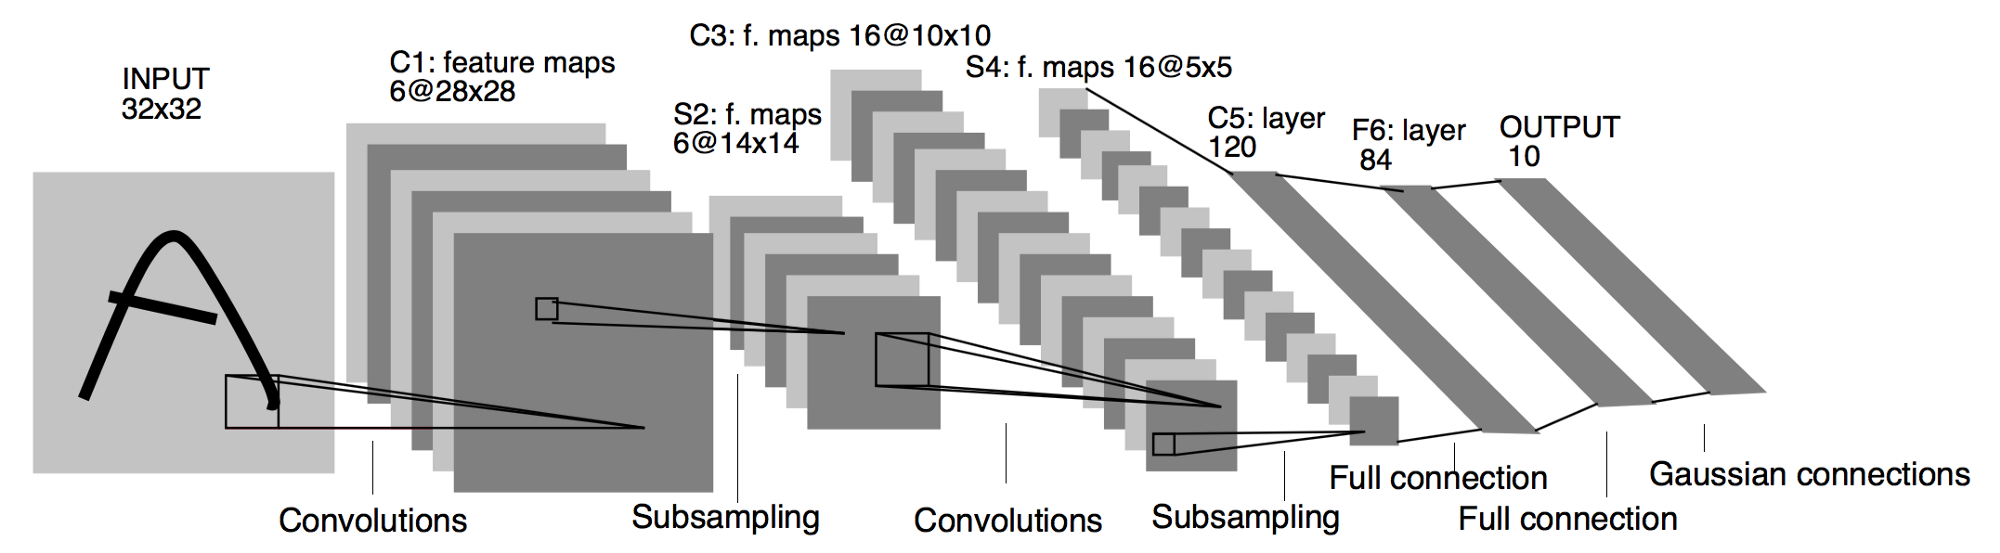

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 输入图像channel：1；输出channel：6；5x5卷积核
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 2x2 Max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 如果是方阵,则可以只使用一个数字进行定义
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # 除去批处理维度的其他所有维度
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [27]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1的权重

10
torch.Size([6, 1, 5, 5])


In [29]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

net.zero_grad()
out.backward(torch.randn(1, 10))

tensor([[-0.0061,  0.0378,  0.0891, -0.1307, -0.0766,  0.0239,  0.0043, -0.0042,
         -0.0946, -0.1105]], grad_fn=<AddmmBackward>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


AlexNet

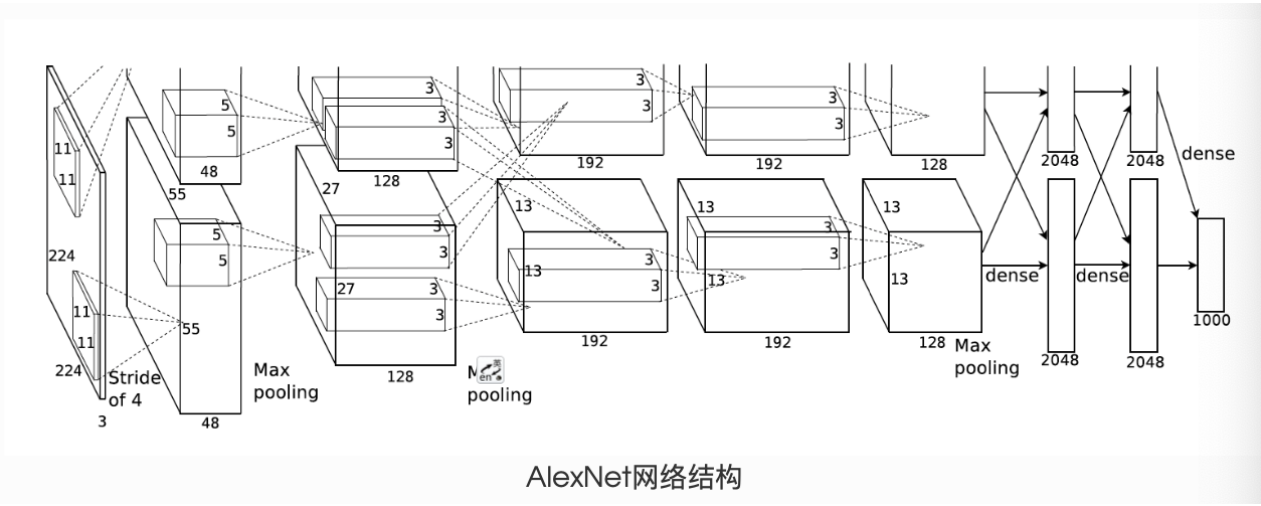

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
         # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(4096, 10),
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

net = AlexNet()
print(net)

### 损失函数

In [ ]:
# 二分类交叉熵损失函数
torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')

In [ ]:
# 交叉熵损失函数
torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

In [ ]:
# L1损失函数
torch.nn.L1Loss(size_average=None, reduce=None, reduction='mean')

In [ ]:
# MSE损失函数
torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

In [ ]:
# 平滑L1 (Smooth L1)损失函数
torch.nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean', beta=1.0)

### 优化器

In [32]:
import os
import torch

# 设置权重，服从正态分布  --> 2 x 2
weight = torch.randn((2, 2), requires_grad=True)
# 设置梯度为全1矩阵  --> 2 x 2
weight.grad = torch.ones((2, 2))
# 输出现有的weight和data
print("The data of weight before step:\n{}".format(weight.data))
print("The grad of weight before step:\n{}".format(weight.grad))
# 实例化优化器
optimizer = torch.optim.SGD([weight], lr=0.1, momentum=0.9)
# 进行一步操作
optimizer.step()
# 查看进行一步后的值，梯度
print("The data of weight after step:\n{}".format(weight.data))
print("The grad of weight after step:\n{}".format(weight.grad))
# 权重清零
optimizer.zero_grad()
# 检验权重是否为0
print("The grad of weight after optimizer.zero_grad():\n{}".format(weight.grad))
# 输出参数
print("optimizer.params_group is \n{}".format(optimizer.param_groups))
# 查看参数位置，optimizer和weight的位置一样，我觉得这里可以参考Python是基于值管理
print("weight in optimizer:{}\nweight in weight:{}\n".format(id(optimizer.param_groups[0]['params'][0]), id(weight)))
# 添加参数：weight2
weight2 = torch.randn((3, 3), requires_grad=True)
optimizer.add_param_group({"params": weight2, 'lr': 0.0001, 'nesterov': True})
# 查看现有的参数
print("optimizer.param_groups is\n{}".format(optimizer.param_groups))
# 查看当前状态信息
opt_state_dict = optimizer.state_dict()
print("state_dict before step:\n", opt_state_dict)
# 进行5次step操作
for _ in range(50):
    optimizer.step()
# 输出现有状态信息
print("state_dict after step:\n", optimizer.state_dict())
# 保存参数信息
torch.save(optimizer.state_dict(),os.path.join(r"./", "optimizer_state_dict.pkl"))
print("----------done-----------")
# 加载参数信息
state_dict = torch.load(r"./optimizer_state_dict.pkl") # 需要修改为你自己的路径
optimizer.load_state_dict(state_dict)
print("load state_dict successfully\n{}".format(state_dict))
# 输出最后属性信息
print("\n{}".format(optimizer.defaults))
print("\n{}".format(optimizer.state))
print("\n{}".format(optimizer.param_groups))


The data of weight before step:
tensor([[ 1.5028,  1.5596],
        [ 0.7605, -0.7993]])
The grad of weight before step:
tensor([[1., 1.],
        [1., 1.]])
The data of weight after step:
tensor([[ 1.4028,  1.4596],
        [ 0.6605, -0.8993]])
The grad of weight after step:
tensor([[1., 1.],
        [1., 1.]])
The grad of weight after optimizer.zero_grad():
tensor([[0., 0.],
        [0., 0.]])
optimizer.params_group is 
[{'params': [tensor([[ 1.4028,  1.4596],
        [ 0.6605, -0.8993]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}]
weight in optimizer:140481833507568
weight in weight:140481833507568

optimizer.param_groups is
[{'params': [tensor([[ 1.4028,  1.4596],
        [ 0.6605, -0.8993]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}, {'params': [tensor([[ 0.3209,  0.4296,  0.0350],
        [-1.6136,  1.2943, -3.4059],
        [-1.5271,  2.2544, -1.5326]], requ

### 训练与评估

In [36]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(label, output)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))



In [37]:
def val(epoch):       
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output, 1)
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
            running_accu += torch.sum(preds == label.data)
    val_loss = val_loss/len(val_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, val_loss))